In [2]:
import sys
sys.path.append('../src/')
from harp_loader import read_harp_bin 

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:

df  = read_harp_bin(r"D:\672107\20230920T125148\Behavior\Register__44.bin")
perimeter = 15*np.pi
resolution = perimeter / -8192
df['velocity'] = (df[1] * resolution)*1000

In [33]:
odor_df  = read_harp_bin(r"D:\672107\20230920T125148\Behavior\Register__34.bin")


In [4]:
water_on = read_harp_bin(r"D:\672107\20230920T125148\Behavior\Register__34.bin")
water_on = water_on.loc[water_on['Value'] & 0x08 > 0] * 0 + 1
water_off = read_harp_bin(r"D:\672107\20230920T125148\Behavior\Register__35.bin")
water_off = water_off.loc[water_off['Value'] & 0x08 > 0] * 0
water = pd.concat([water_on, water_off], join='outer', sort=True)


In [5]:
odor1_on = read_harp_bin(r"D:\672107\20230920T125148\Behavior\Register__34.bin")
odor1_on = odor1_on.loc[odor1_on['Value'] & 16 > 0] * 0 + 1
odor1_off = read_harp_bin(r"D:\672107\20230920T125148\Behavior\Register__35.bin")
odor1_off = odor1_off.loc[odor1_off['Value'] & 16 > 0] * 0
odor1 = pd.concat([odor1_on, odor1_off], join='outer').sort_index()
odor1 = odor1.loc[odor1.Value.diff() != 0]

(98860.0, 98885.0)

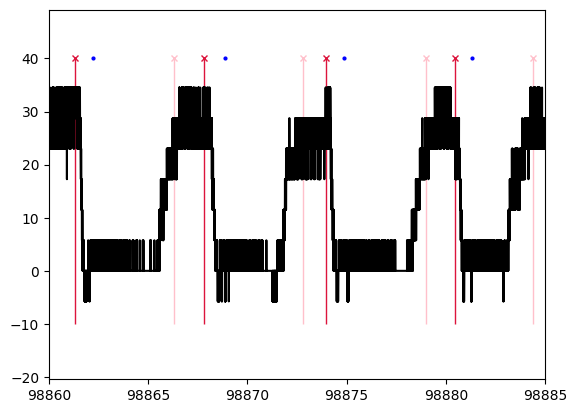

In [6]:
plt.plot(odor1.loc[odor1.Value == 1].index,  np.repeat(40, len(odor1.loc[odor1.Value == 1])),  marker='x', linestyle='none', markersize=5, color='crimson')
plt.vlines(odor1.loc[odor1.Value == 1].index, ymin=-10, ymax=40, color='crimson', linewidth=1)

plt.plot(odor1.loc[odor1.Value == 0].index,  np.repeat(40, len(odor1.loc[odor1.Value == 0])),  marker='x', linestyle='none', markersize=5, color='pink')
plt.vlines(odor1.loc[odor1.Value == 0].index, ymin=-10, ymax=40, color='pink', linewidth=1)

plt.plot(water.index,  np.repeat(40, len(water)),  marker='o', linestyle='none', markersize=2, color='blue')
plt.plot(df.velocity, color='black')
plt.xlim(98860, 98885)

In [37]:
# // calculate running window for velocity in df
def running_average(numbers, window_size):
    if window_size <= 0:
        raise ValueError("Window size must be greater than 0")
    
    running_averages = []
    window_sum = 0
    
    for i, num in enumerate(numbers):
        window_sum += num
        
        if i >= window_size - 1:
            average = window_sum / window_size
            running_averages.append(average)
            window_sum -= numbers[i - window_size + 1]
    
    return running_averages

In [7]:
#------------------------------------------------
# Create a FIR filter and apply it to signal.
#------------------------------------------------
# The Nyquist rate of the signal.
from scipy.signal import lfilter, firwin
nyq_rate = 1000 / 2.

# The cutoff frequency of the filter: 6KHz
cutoff_hz = 5.0

# Length of the filter (number of coefficients, i.e. the filter order + 1)
numtaps = 61

# Use firwin to create a lowpass FIR filter
fir_coeff = firwin(numtaps, cutoff_hz/nyq_rate)

# Use lfilter to filter the signal with the FIR filter
filtered_signal = lfilter(fir_coeff, 1.0, df["velocity"].values)


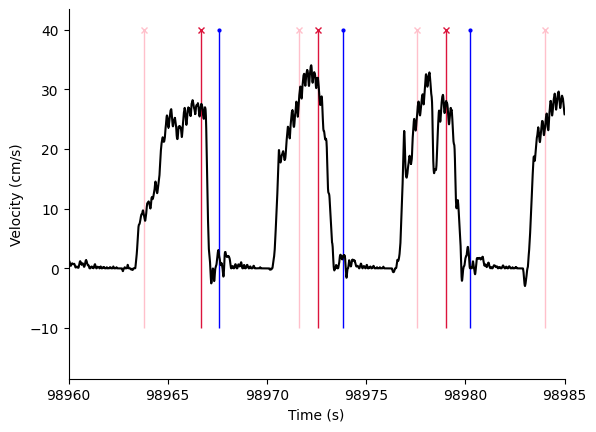

In [17]:
plt.plot(odor1.loc[odor1.Value == 1].index,  np.repeat(40, len(odor1.loc[odor1.Value == 1])),  marker='x', linestyle='none', markersize=5, color='crimson')
plt.vlines(odor1.loc[odor1.Value == 1].index, ymin=-10, ymax=40, color='crimson', linewidth=1)

plt.plot(odor1.loc[odor1.Value == 0].index,  np.repeat(40, len(odor1.loc[odor1.Value == 0])),  marker='x', linestyle='none', markersize=5, color='pink')
plt.vlines(odor1.loc[odor1.Value == 0].index, ymin=-10, ymax=40, color='pink', linewidth=1)

plt.plot(water.index,  np.repeat(40, len(water)),  marker='o', linestyle='none', markersize=2, color='blue')
plt.vlines(water.index, ymin=-10, ymax=40, color='blue', linewidth=1)

plt.plot(df.index.values, filtered_signal, color='black')
plt.xlim(98960, 98985)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (cm/s)')
sns.despine()

In [14]:
window_size = 20

def running_average_with_edges(numbers, window_size):
    if window_size <= 0:
        raise ValueError("Window size must be greater than 0")

    half_window = window_size // 2
    running_averages = []

    for i in range(len(numbers)):
        window_start = max(0, i - half_window)
        window_end = min(len(numbers), i + half_window + 1)
        window_values = numbers[window_start:window_end]

        average = sum(window_values) / len(window_values)
        running_averages.append(average)

    return running_averages

In [41]:
import json

# //load json file
with open(r'D:\672107\20230920T125148\config.json') as f:
  data = json.load(f)

In [ ]:
df['time_intervals']= df.index.diff()
df.fillna(0.001, inplace=True)
df

In [ ]:
def calculate_distance(speeds, time_intervals):
    if len(speeds) != len(time_intervals):
        raise ValueError("Length of speeds and time_intervals must be the same")

    distance = 0.0

    for i in range(len(speeds)):
        delta_t = time_intervals[i]
        v = speeds[i]
        distance += v * delta_t

    return distance

# Example usage:
speeds = df["velocity"].values  # Instantaneous speeds in m/s
time_intervals = df['time_intervals'].values  # Time intervals in seconds

total_distance = calculate_distance(speeds, time_intervals)
print(f"Total distance traveled: {total_distance} meters")


In [ ]:

def calculate_instantaneous_positions(speeds, time_intervals):
    if len(speeds) != len(time_intervals):
        raise ValueError("Length of speeds and time_intervals must be the same")

    positions = [0.0]  # Initialize with an initial position of 0
    for i in range(len(speeds)):
        delta_t = time_intervals[i]
        v = speeds[i]
        position = positions[-1] + v * delta_t
        positions.append(position)
    
    return positions[1:]

# Example usage:
speeds = df["velocity"].values  # Instantaneous speeds in m/s
time_intervals = df['time_intervals'].values  # Time intervals in seconds

instantaneous_positions = calculate_instantaneous_positions(speeds, time_intervals)
print("Instantaneous positions (meters):", instantaneous_positions)
df['instantaneous_positions'] = instantaneous_positions